In [1]:
import os
import pandas as pd
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import datetime
#pd.show_versions(as_json=False)

threshold = 1000

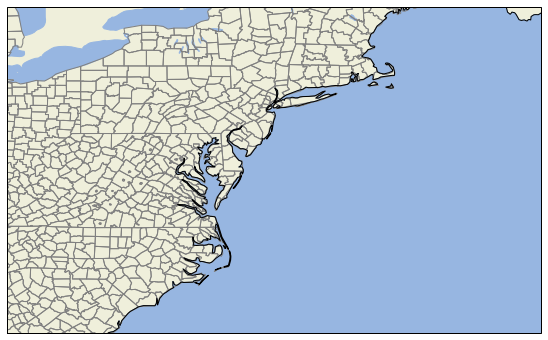

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt


#reader = shpreader.Reader('../other3p/county/countyl010g.shp')
reader = shpreader.Reader('../other3p/uscounties/uscounties.shp')

county_records = list(reader.records())
counties = [r.geometry for r in county_records]

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')

ax.coastlines('50m')

ax.set_extent([-83, -65, 33, 44])
plt.show()

In [3]:
for c in county_records[80:85]:
    print(c.attributes)

{'NAME': 'Dawson', 'STATE_NAME': 'Montana', 'STATE_FIPS': '30', 'CNTY_FIPS': '021', 'FIPS': '30021'}
{'NAME': 'King', 'STATE_NAME': 'Washington', 'STATE_FIPS': '53', 'CNTY_FIPS': '033', 'FIPS': '53033'}
{'NAME': 'Cascade', 'STATE_NAME': 'Montana', 'STATE_FIPS': '30', 'CNTY_FIPS': '013', 'FIPS': '30013'}
{'NAME': 'Griggs', 'STATE_NAME': 'North Dakota', 'STATE_FIPS': '38', 'CNTY_FIPS': '039', 'FIPS': '38039'}
{'NAME': 'Steele', 'STATE_NAME': 'North Dakota', 'STATE_FIPS': '38', 'CNTY_FIPS': '091', 'FIPS': '38091'}


In [4]:
# Load Data
def load_raw(fn):
    datapath = os.path.join('../csse_covid_19_data/csse_covid_19_time_series/', fn)

    #datapath = '../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    
    raw = pd.read_csv(datapath)
    #del raw['Lat']
    #del raw['Long']
    #raw= raw.replace('Mainland China','China')
    raw = raw[raw.iso2=='US']
    raw = raw[pd.notnull(raw.UID) & ~(raw.Lat==0.0)]
    # fix HI/AK later
    raw = raw[~(raw.Province_State=='Alaska') & ~(raw.Province_State=='Hawaii')]
    return raw

raw = load_raw('time_series_covid19_confirmed_us.csv')
#raw_deaths = load_raw('time_series_covid19_deaths_global.csv')

raw


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,560,583,607,610,636,643,653,662,676,698
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,828,846,864,894,980,1039,1114,1170,1207,1277
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,345,347,349,353,357,362,367,377,394,399
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,186,187,190,194,196,198,208,215,221,224
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,226,230,235,243,251,258,273,281,296,320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256,84070016,US,USA,840,NaN,Central Utah,Utah,US,39.372319,-111.575868,...,194,201,209,217,227,234,243,263,266,270
3257,84070017,US,USA,840,NaN,Southeast Utah,Utah,US,38.996171,-110.701396,...,40,40,40,41,41,45,47,50,54,54
3258,84070018,US,USA,840,NaN,Southwest Utah,Utah,US,37.854472,-111.441876,...,1625,1660,1689,1731,1805,1840,1881,1949,2005,2069
3259,84070019,US,USA,840,NaN,TriCounty,Utah,US,40.124915,-109.517442,...,53,55,55,56,56,59,63,63,65,69


In [5]:
raw[raw['FIPS']==53033]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20
2974,84053033,US,USA,840,53033.0,King,Washington,US,47.491379,-121.834613,...,10684,10782,10941,11105,11182,11284,11419,11568,11568,11825


In [13]:
#%%capture
%matplotlib inline
from math import log
from numpy import maximum

x=raw['Long_']
y=raw['Lat']
#c=raw['4/19/20'].apply(lambda x: log(x) if x>0 else 0)
weeks = 16
window = 7
dates=raw.columns[-weeks*7:]
#print(dates)
new = [(raw[dates[i]]-raw[dates[i-window]]).clip(0)/window for i in range(window,len(dates))]
#print(new)
cummax=maximum.accumulate(new, axis=0)
#print(np.shape(cummax), np.shape(new))
#print(new[0][:10], cummax[0,:10])

series = [new[i].divide(cummax[i,:]).fillna(0) for i in range(len(new))]
#print(series[0])

maxval=max([c.max() for c in series])
print(maxval)
#print(series)
#print(c.min(),c.max())

#ax.set_extent([-83, -65, 33, 44])

fips = raw['FIPS'].fillna(-1).apply(lambda x: int(x))

cty_fips = set([int(r.attributes['FIPS']) for r in county_records])
raw_fips = set(fips)

#print(cty_fips.difference(raw_fips))
#print(raw_fips.difference(cty_fips))

#print(list(sorted(cty_fips))[:10])
#print(list(sorted(raw_fips))[:10])

#plt.show()
lookup_0 = dict(zip(list(fips),list(raw['Admin2'])))
test_mapping = zip([r.attributes['NAME'] for r in county_records], [lookup_0[int(r.attributes['FIPS'])] if int(r.attributes['FIPS']) in lookup_0 else 'missing' for r in county_records])
#for (r,l) in test_mapping:
#    print(r,l)

#cmap=plt.cm.autumn_r
#cmap = plt.cm.plasma
cmap = plt.cm.rainbow
#norm=plt.Normalize(min(mapping),max(mapping))
norm=plt.Normalize(0,maxval)
    
from math import exp

def plot_map(date_tuple):
    c,dt,ax = date_tuple
    print(dt)
    # todo: this could be done outside the call.
    #print(len(fips),len(c))
    lookup = dict(zip(list(fips),c))
    #print(lookup)
    if c.max()>1:
        print([x for x in c if x>1])
    mapping = [lookup[int(r.attributes['FIPS'])] if int(r.attributes['FIPS']) in lookup else 0.0 for r in county_records]    
    mapping_ext = []
    for (m,c) in zip(mapping,counties):
        mapping_ext+=[m]*len(c.geoms)
    #print(mapping)
    #print(min(mapping),max(mapping))
    #print(len(mapping),len(counties))
    #print(dt)
    ax.clear()
    ax.add_feature(cfeature.LAND.with_scale('50m'))
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax.add_feature(cfeature.LAKES.with_scale('50m'))
    #print(max(mapping),cmap(norm(max(mapping))))
    #add_feature(COUNTIES
    ax.add_geometries(counties, ccrs.PlateCarree(), facecolor=list(cmap(norm(mapping_ext))), edgecolor='gray', linewidth=0.1)
    ax.coastlines('50m')

    #ax.scatter(x,y, c=c, alpha=0.5, cmap='autumn_r')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_extent([-76,-72,38,42]) # Manhattan
    #ax.set_extent([-83, -65, 33, 44]) Eastern Seaboard
    #ax.set_extent([-124,-120,46,49]) # Western WA
    ax.set_extent([-130,-62,20,50]) # US
    plt.box(False)
    ax.text(0.95, 0.15, dt, transform=ax.transAxes, color='#222222', size=24, ha='right', weight=800)



1.0


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


3/30/20
3/30/20
3/31/20
4/1/20
4/2/20
4/3/20
4/4/20
4/5/20
4/6/20
4/7/20
4/8/20
4/9/20
4/10/20
4/11/20
4/12/20
4/13/20
4/14/20
4/15/20
4/16/20
4/17/20
4/18/20
4/19/20
4/20/20
4/21/20
4/22/20
4/23/20
4/24/20
4/25/20
4/26/20
4/27/20
4/28/20
4/29/20
4/30/20
5/1/20
5/2/20
5/3/20
5/4/20
5/5/20
5/6/20
5/7/20
5/8/20
5/9/20
5/10/20
5/11/20
5/12/20
5/13/20
5/14/20
5/15/20
5/16/20
5/17/20
5/18/20
5/19/20
5/20/20
5/21/20
5/22/20
5/23/20
5/24/20
5/25/20
5/26/20
5/27/20
5/28/20
5/29/20
5/30/20
5/31/20
6/1/20
6/2/20
6/3/20
6/4/20
6/5/20
6/6/20
6/7/20
6/8/20
6/9/20
6/10/20
6/11/20
6/12/20
6/13/20
6/14/20
6/15/20
6/16/20
6/17/20
6/18/20
6/19/20
6/20/20
6/21/20
6/22/20
6/23/20
6/24/20
6/25/20
6/26/20
6/27/20
6/28/20
6/29/20
6/30/20
7/1/20
7/2/20
7/3/20
7/4/20
7/5/20
7/6/20
7/7/20
7/8/20
7/9/20
7/10/20
7/11/20
7/12/20


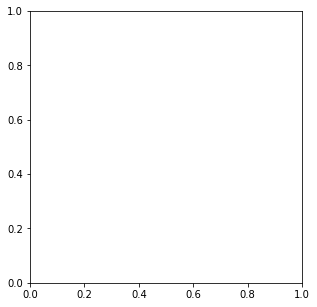

3/30/20


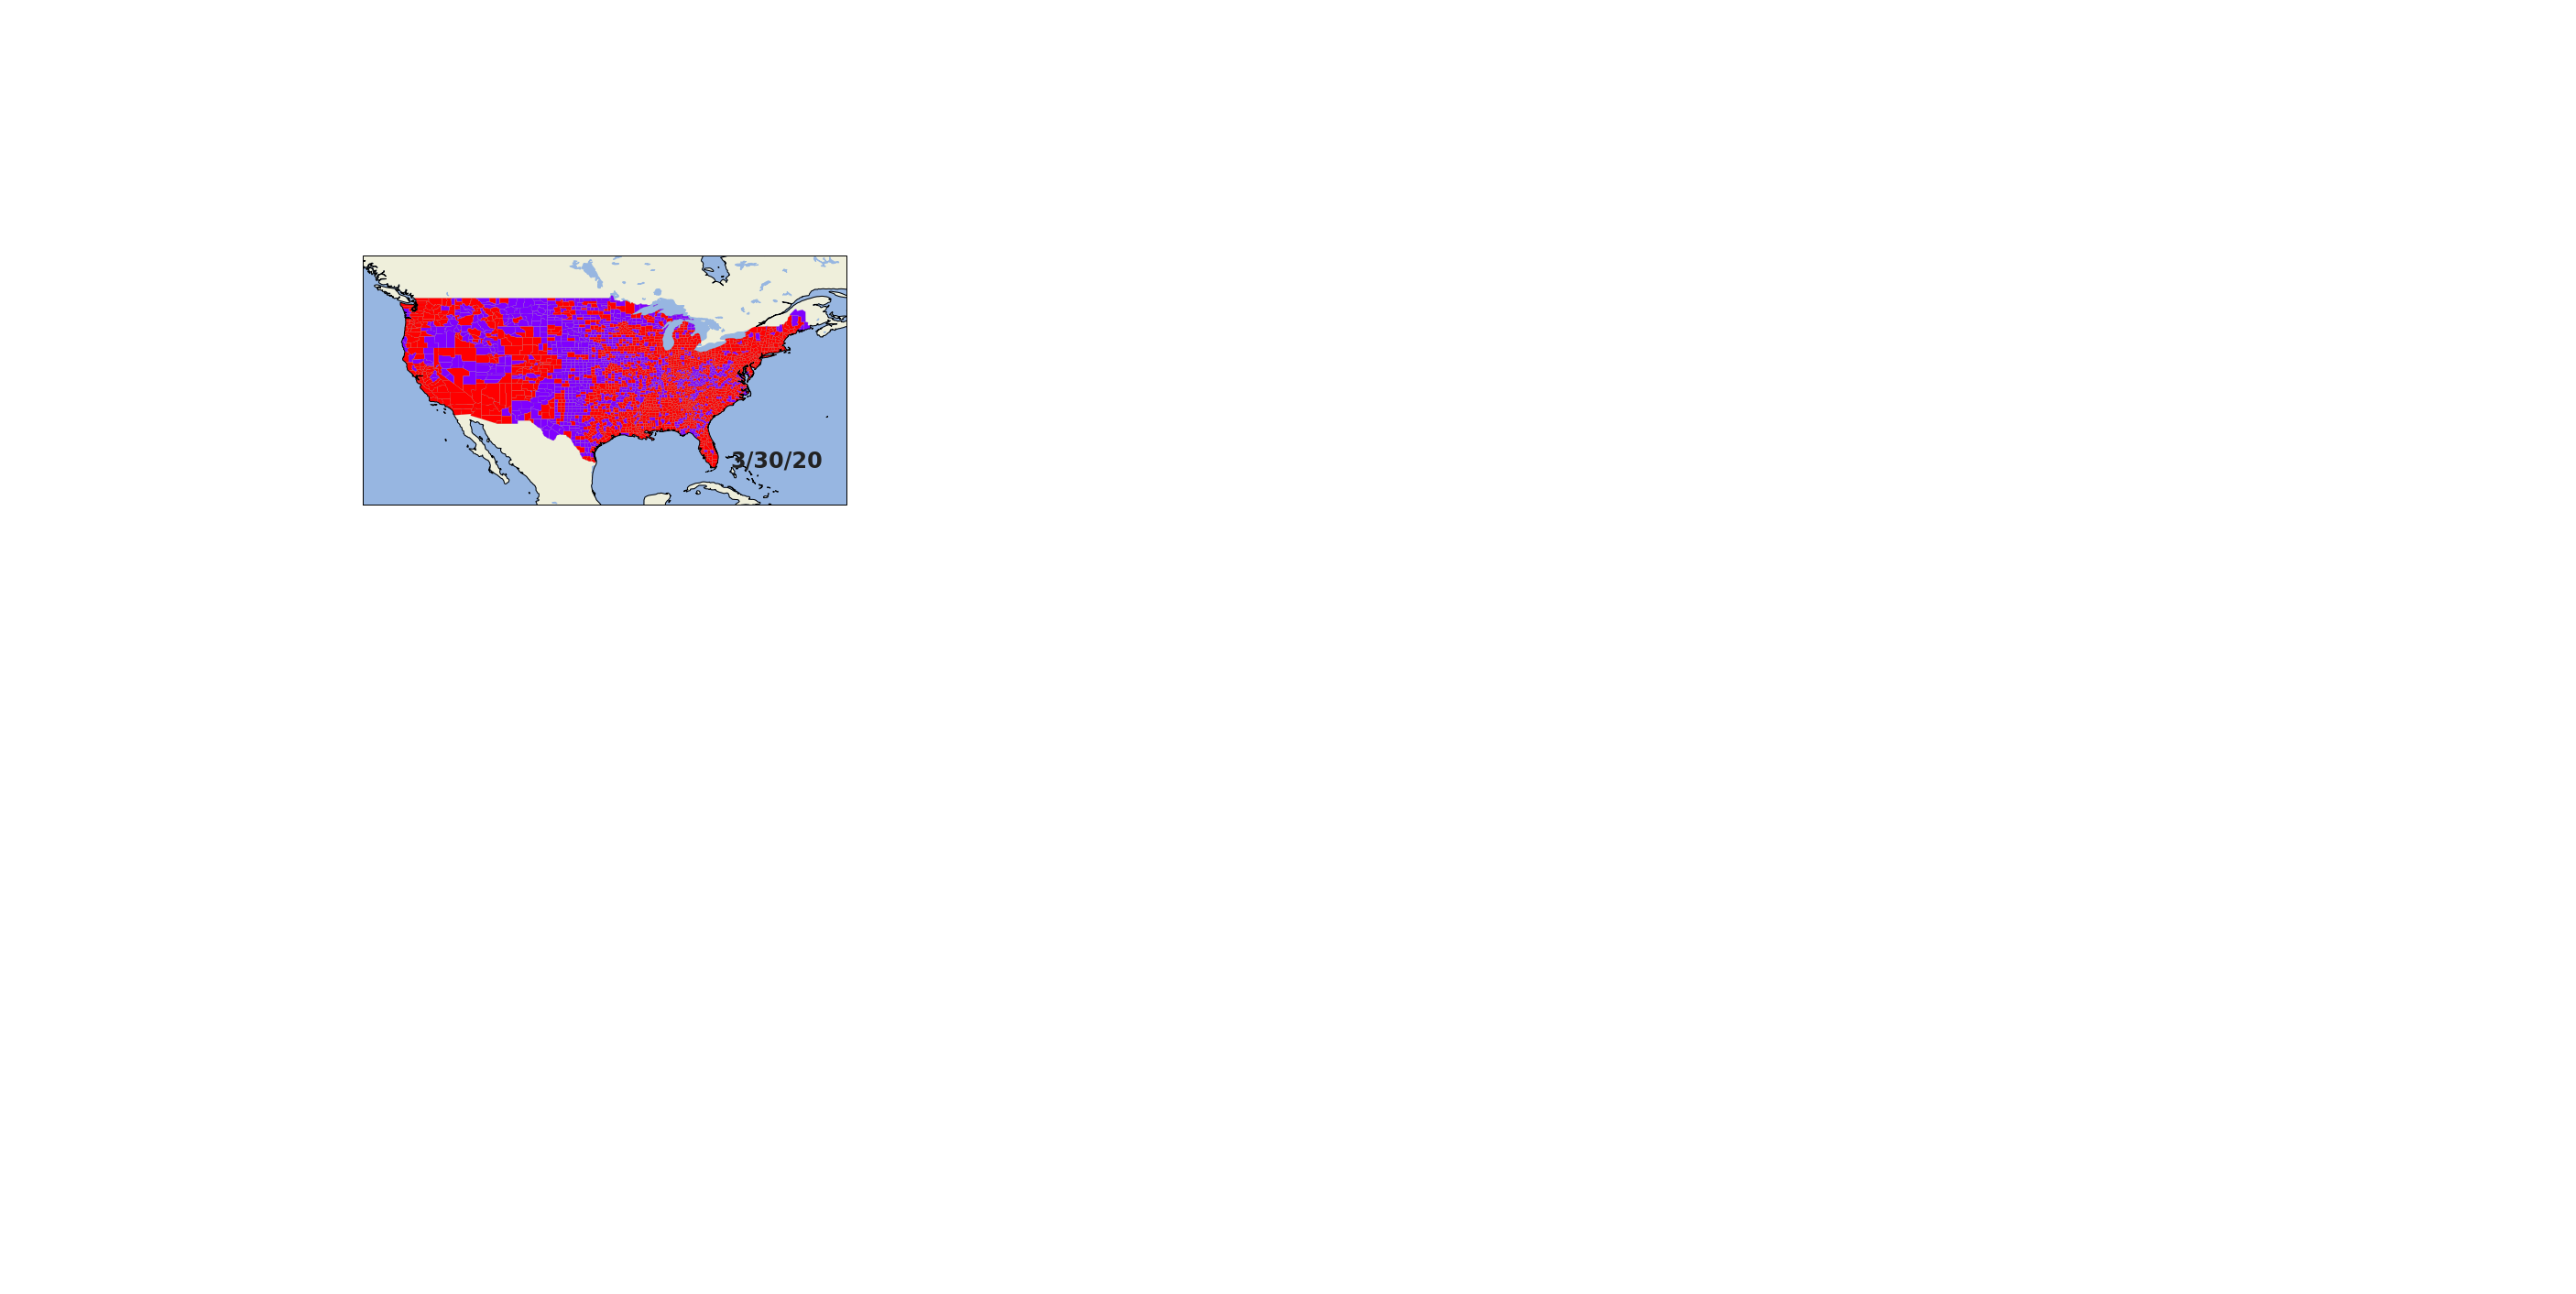

In [14]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.gca().set_aspect('equal', adjustable='box')
#fig, ax= plt.subplots()
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

frames = list(zip(series,dates[window:],[ax]*len(series)))

animate = True
if animate: 
    animator = animation.FuncAnimation(fig, plot_map, frames=frames, repeat=False)
    animator.save('data/animation-p0-latest.gif')
else:
    plot_map(frames[-1])

#HTML(animator.to_jshtml()) 
#
#maxDate=raw.columns[-1].replace('/','-')
#animator.save('data/animation-fill-{}.gif'.format(maxDate))



In [ ]:
fips